# Homework 2 (Due 01/19/2024)

In [1]:
import sys
from matplotlib import pyplot as plt
import numpy as np
import astropy.units as u

# importing custom functions

sys.path.append("../")
from ASTRO530.functions import integrate_bounds, planck
from ASTRO530 import plotting

## Precision Test (Q3.A,B,C)

In [2]:
def planck_analytic_int(T=5000):
    """
    Calculates the analytical form of the integrated planck function.
    
    Parameters:
    - T (real scalar): temperature value in Kelvin (defualt is 5000 K)

    Returns:
    - Value of the analytical form of the integrated planck function in cgs units.
    """

    from astropy.constants import h, k_B, c, sigma_sb
    import astropy.units as u

    h = h.cgs
    k_B = k_B.cgs
    c = c.cgs
    T = T*u.Kelvin

    B = 2*(np.pi**4)*(k_B**4)*(T**4)/(15*(c**3)*(h**3)) / u.sr
    return B.decompose(u.cgs.bases)

In [3]:
def int_planck(a,b,n,T=5000):
    """
    Numerically integrates the planck function with respect to wave number.
    
    Parameters:
    - a (real scalar): lower limit of integration in wave number
    - b (real scalar): upper limit of integration in wave number
    - n (real integer > 0): number of bins/slices in which the integral is evaluated over
    - T (real scalar): temperature value in Kelvin (defualt is 5000 K)

    Returns:
    - Value of the numerical form of the integrated planck function in cgs units.
    """
    B = integrate_bounds(planck,a,b,n=n,T=T,x_type="wave number")
    return B.decompose(u.cgs.bases)

In [8]:
def int_planck_offset(a,b,n,T=5000):
    """
    Numerically integrates the planck function with respect to wave number with a constant offset of 4pi.
    
    Parameters:
    - a (real scalar): lower limit of integration in wave number
    - b (real scalar): upper limit of integration in wave number
    - n (real integer > 0): number of bins/slices in which the integral is evaluated over
    - T (real scalar): temperature value in Kelvin (defualt is 5000 K)

    Returns:
    - Value of the numerical form of the integrated planck function in cgs units with a constant offset.
    """
    B = integrate_bounds(planck,a,b,n=n,T=T,x_type="wave number")
    B = B*4*np.pi # offset of 4pi to introduce error
    return B.decompose(u.cgs.bases)

In [9]:
def precision(truth,calc):
    """
    Determined the precision of a calculation when provided the true value.
    
    Parameters:
    - truth (scalar): true value
    - calc (scalar): calculated value

    Returns:
    - Absolute value of precision.
    """
    return abs(1-(calc/truth))

In [10]:
def plot_precisions(planck_func,T,file_name):
    """
    Calculates and plots the precision of a provided numerically integrated planck function with respect to the analytical true integrated planck function.
    
    Parameters:
    - planck_func (function): integrated planck function with the arguments of planck_func(a,b,n,T)
    - T (real scalar): temperature value in Kelvin (defualt is 5000 K)
    - file_name (string): name of file output for plot
    """

    B_true = planck_analytic_int(T) # calculating true value of integrated planck function
    
    a_values = np.logspace(-6,0,50) # setting range of values to be tested
    b_values = np.logspace(0,2,50)
    n_values = np.logspace(1,8,50)
    values = np.array([a_values,b_values,n_values])
    
    default_values = [10e-6, 10**(1.5), int(10e5)] # Default values for a, b, and n (best guesses from trial and error)
    
    prec_arrs = []
    B_calcs_all = []
    
    for i, var_values in enumerate(values): # parsing through 3 variables (a, b, n)
        prec_arr = []
        B_calcs = []
        a, b, n = default_values
        for j, val in enumerate(var_values): # parsing through each value in the variable space
    
            if i == 0: # using defualt values for varibles not being actively tested
                a = val.copy()
            elif i == 1:
                b = val.copy()
            elif i == 2:
                n = int(val.copy())
                
            B_calc = planck_func(a / u.micron,b / u.micron,n,T) # evaluating the integral for each value
            prec_arr.append(precision(B_true,B_calc))
        prec_arrs.append(prec_arr)

    fig = plt.figure(figsize=(25,7)) # plotting results
    grid = plt.GridSpec(1,3,wspace=0,hspace=0.4)
    
    for i, var in enumerate(prec_arrs):
        ax = fig.add_subplot(grid[0,i])

        ax.set_ylim(10e-18,100)
        if "offset" in file_name:
            ax.set_ylim(1,20)
    
        ax.loglog(values[i],prec_arrs[i],lw=4,c=['lightblue','cornflowerblue','indigo'][i])
        ax.set_xlabel([r"Lower Limit ($\mathrm{\mu m^{-1}}$)",r"Upper Limit ($\mathrm{\mu m^{-1}}$)","Number of Bins"][i])
        
        ax.grid()
        if i > 0:
            ax.set_yticklabels([])
        if i == 0:
            ax.set_ylabel("Precision")

    plt.savefig(f"../Plots/HW2/{file_name}.png")
    plt.show()

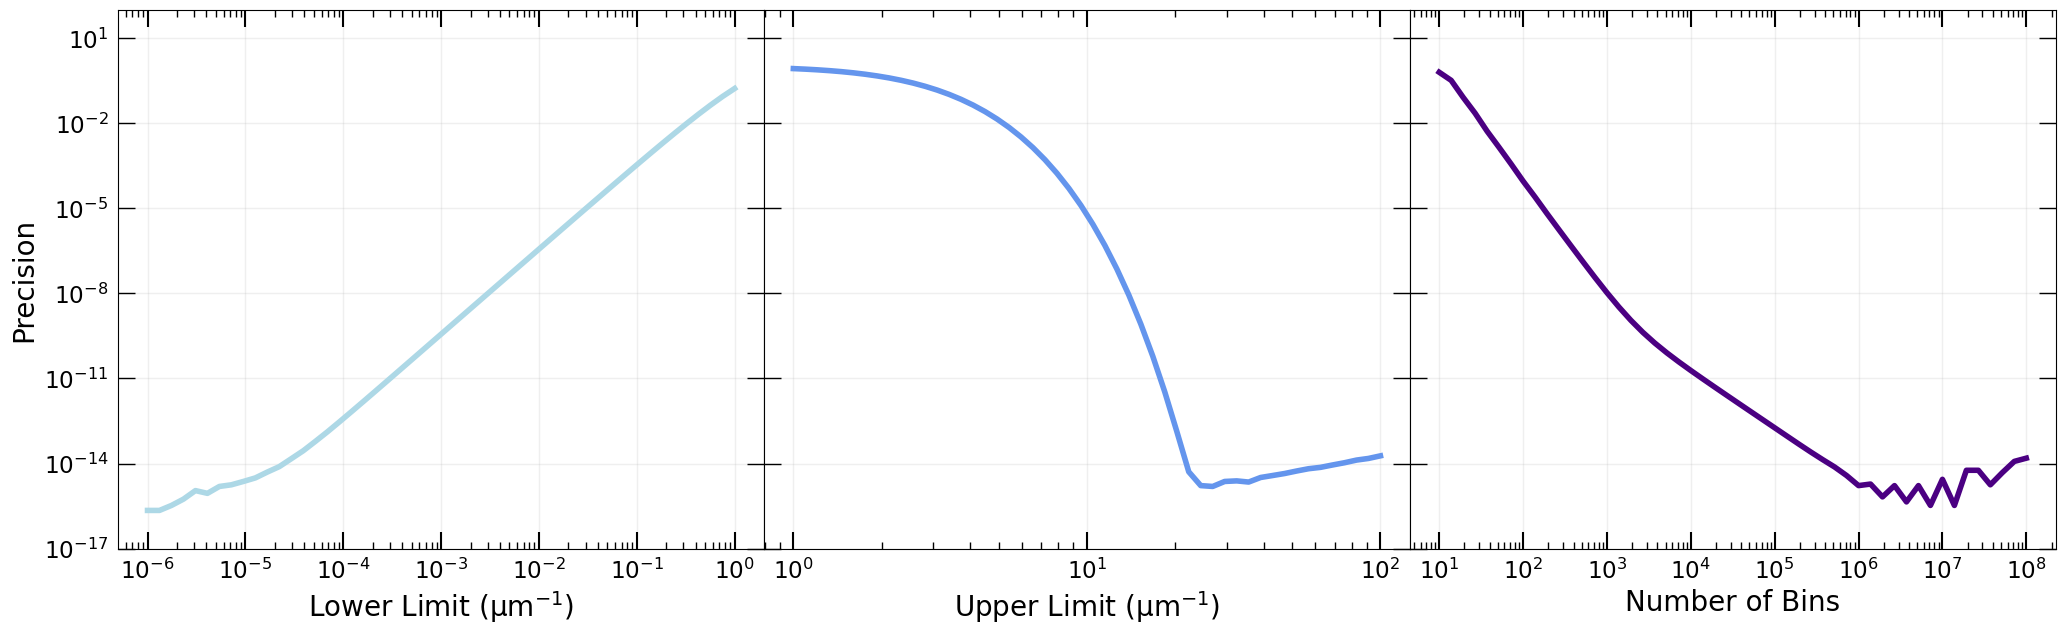

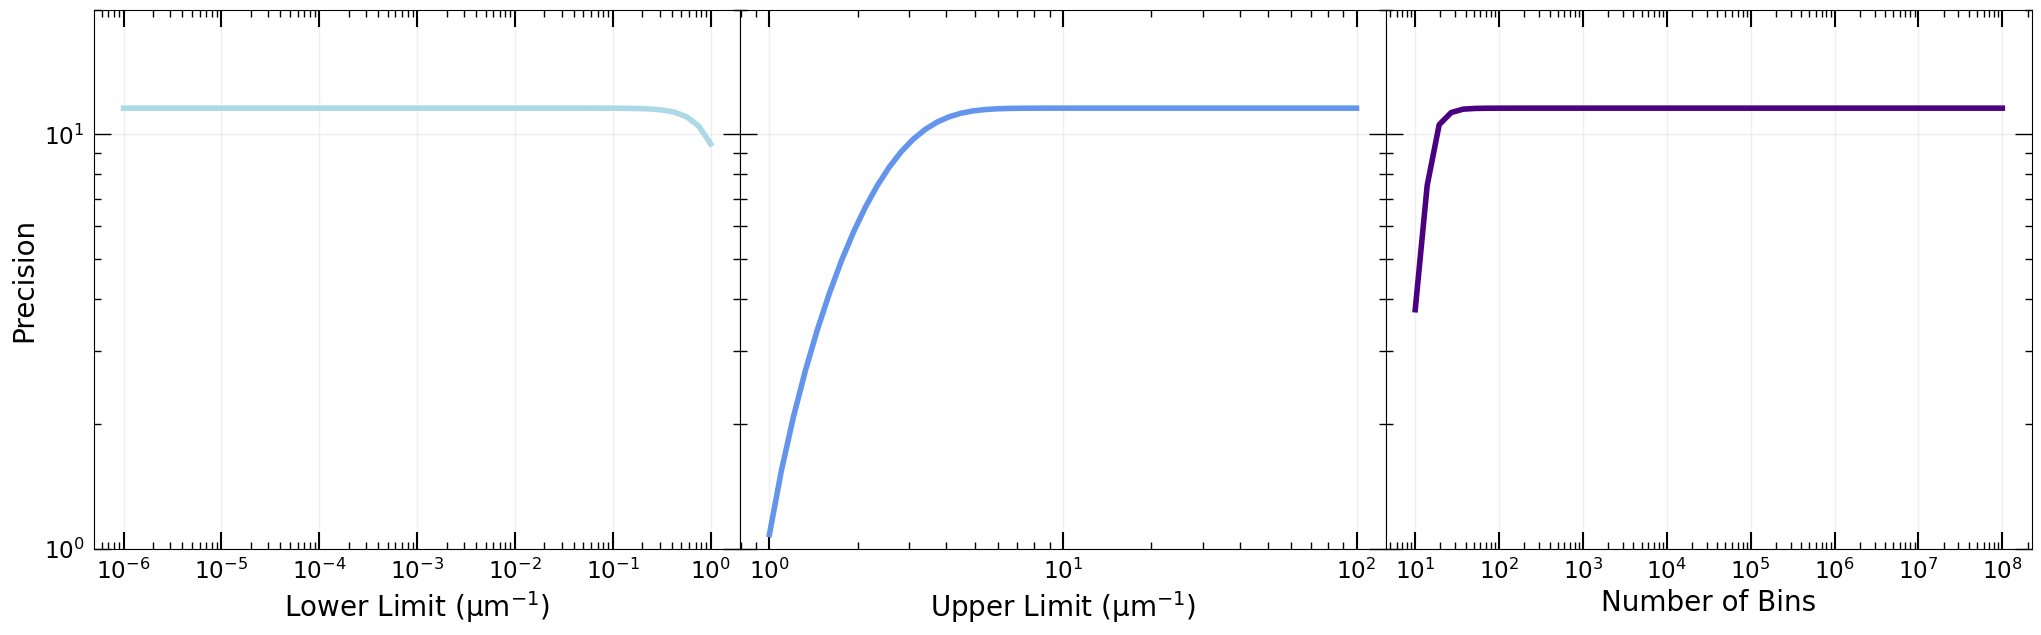

In [11]:
plot_precisions(int_planck,7500,"precisions") # precision test
plot_precisions(int_planck_offset,7500,"precisions_offset") # precision test with an offset of 4pi

## Convergence Test (Q3.D)

In [14]:
def test_convergence(T,tol):
    """
    Calculates and plots the convergence of a provided numerically integrated planck function by altering the upper and lower limits of integration, and the number bins/slices that the integral is evaluated over.
    
    Parameters:
    - T (real scalar): temperature value in Kelvin (defualt is 5000 K)
    - tol (real scalar > 0): tolerance of percent difference of the evaluated integral of the planck function between i and i+1 iterations (recomended to be 1 > tol > 0).
    """
    assert tol > 0., "The tolerance must be greater than 0."
    
    starting_values = np.array([0.9,1,5]) # starting values of variables
    resolution = np.array([-0.01,0.1,1]) # step size for testing convergence
    default_values = [10e-6, 10**(1.5), int(10e5)] # Default values for a, b, and n (best guesses from trial and error)
    
    prec_arrs = []
    values_tested = []

    B_converged = []
    
    for i, val in enumerate(starting_values): # parsing through 3 variables (a, b, n)
        print("Testing the convergence of",["a","b","n"][i],"...")
        prec_arr = []
        B_calcs = []
        values = []
        a, b, n = default_values
        B_calc_prev = None
        iteration = 0
        while True:
            iteration += 1
    
            if i == 0:
                a = val.copy()
            elif i == 1:
                b = val.copy()
            elif i == 2:
                n = int(val.copy())
                
            B_calc = int_planck(a / u.micron,b / u.micron,n,T) # evaluating the integral for each value
            prec_arr.append(B_calc.value)
            values.append(val)
            
            if B_calc_prev is not None and abs(B_calc.value - B_calc_prev.value)/B_calc_prev.value < tol: # testing if the percent change is less than tolerance
                B_converged.append(B_calc.value)
                print(f"Convergence found after {iteration} iterations!")
                print(f"The value of the integration after convergence was reached:",B_calc)
                print(f"The value the variable after convergence was reached:",val,[u.micron**(-1),u.micron**(-1),"bins",][i])
                print(f"---------------------------")
                break
            if iteration > 100:
                print("Too many iterations.")
                print("Latest percent difference:",abs(B_calc.value - B_calc_prev.value)/B_calc_prev.value)
                print("The last value tested was:",val)
                print(f"---------------------------")
                break
    
            val += resolution[i] # testing next step
            B_calc_prev = B_calc # setting reference point for convergence
            
        prec_arrs.append(prec_arr)
        values_tested.append(values)

    fig = plt.figure(figsize=(25,7)) # plotting results of convergence test
    grid = plt.GridSpec(1,3,wspace=0.3,hspace=0.4)
    
    for i, var in enumerate(prec_arrs):
        ax = fig.add_subplot(grid[0,i])

        # ax.set_ylim(0.1,3)
        ax.axhline(np.mean(np.array(B_converged)),label="Average Converged Value",linestyle="--",c="gray",lw=4,alpha=0.3)
        ax.scatter(values_tested[i][-1],prec_arrs[i][-1],s=150,c=['lightblue','cornflowerblue','indigo'][i],label="Final Variable Value")
        ax.loglog(values_tested[i],prec_arrs[i],lw=4,c=['lightblue','cornflowerblue','indigo'][i],label="Path of Convergence")
        ax.set_xlabel([r"Lower Limit ($\mathrm{\mu m^{-1}}$)",r"Upper Limit ($\mathrm{\mu m^{-1}}$)","Number of Bins"][i])
        ax.grid()
        ax.legend()

        if i == 0:
            ax.set_ylabel(r"$B(T) \ [\mathrm{erg \ s^{-1} \ cm^{-2} \ sr^{-1}}]$")

    plt.savefig(f"../Plots/HW2/convergence.png")
    plt.show()
    

Testing the convergence of a ...
Convergence found after 89 iterations!
The value of the integration after convergence was reached: 1.9049561079455153 g / (cm rad2 s2)
The value the variable after convergence was reached: 0.01999999999999936 1 / micron
---------------------------
Testing the convergence of b ...
Convergence found after 77 iterations!
The value of the integration after convergence was reached: 1.9048529696998593 g / (cm rad2 s2)
The value the variable after convergence was reached: 8.599999999999987 1 / micron
---------------------------
Testing the convergence of n ...
Convergence found after 79 iterations!
The value of the integration after convergence was reached: 1.9045949093386472 g / (cm rad2 s2)
The value the variable after convergence was reached: 83.0 bins
---------------------------


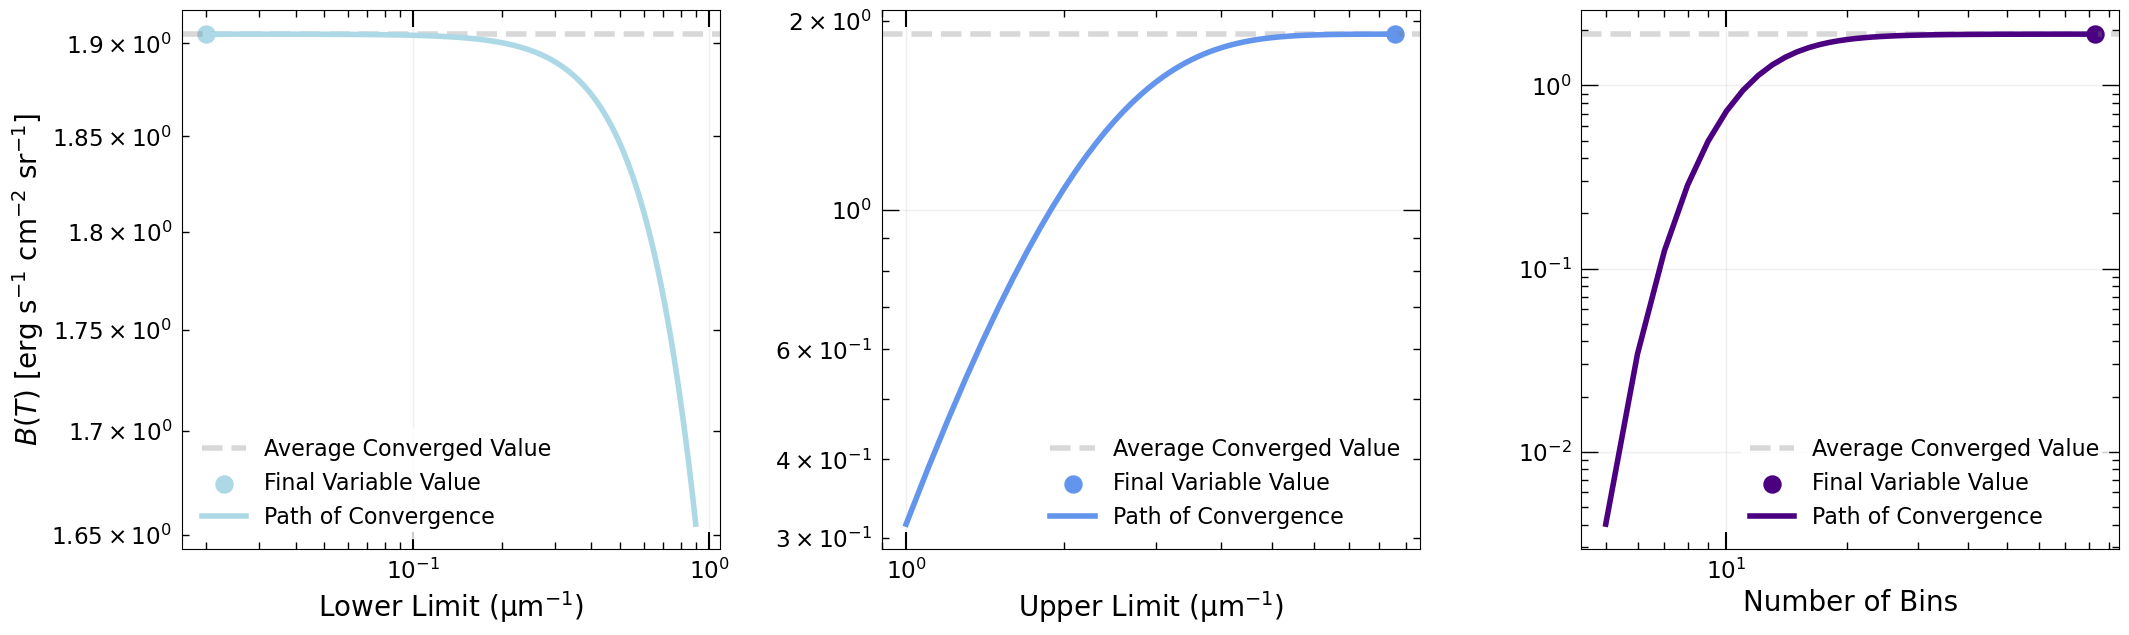

In [15]:
test_convergence(7500,10e-6) # setting tolerance to 10e-6